# **1. Importing Libraries**
Import necessary libraries for data manipulation (Pandas, NumPy), machine learning (scikit-learn), neural networks (TensorFlow/Keras), and data visualization (Matplotlib).


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K


# **2. Load and Preprocess Data**
Load the training and testing datasets and split the features (input) and target (output) values. Ensure data types are float for compatibility with TensorFlow.

In [ ]:
train_file_path = "train_dataset.csv"  # Replace with your actual training dataset path
test_file_path = "test_dataset.csv"    # Replace with your actual test dataset path

# Load the datasets
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Process the training dataset
train_features = train_data.iloc[:, :-1].values.astype(float)
train_target = train_data.iloc[:, -1].values.astype(float)

# Process the testing dataset
test_features = test_data.iloc[:, :-1].values.astype(float)
test_target = test_data.iloc[:, -1].values.astype(float)


# **3. Sequence Preparation**
Define a helper function to reshape datasets into sequences based on the specified group size for the LSTM model. Validate compatibility with the group size.

In [ ]:
# Define group size
group_size = 9

# Ensure both datasets are compatible with group_size
def prepare_sequences(features, target, group_size):
    if len(features) % group_size != 0:
        raise ValueError(f"Number of rows in the dataset ({len(features)}) is not a multiple of {group_size}.")
    num_groups = len(features) // group_size
    X = features.reshape(num_groups, group_size, -1)
    y = target.reshape(num_groups, group_size, 1)
    return X, y

X_train_full, y_train_full = prepare_sequences(train_features, train_target, group_size)
X_test, y_test = prepare_sequences(test_features, test_target, group_size)


# **4. Train-Validation Split**
Split the training dataset into training and validation sets in an 80:20 ratio for model evaluation.



In [ ]:
# Split the training data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)


# **5. Model Architecture**
Define the Bidirectional LSTM model for sequence regression. The model includes two LSTM layers and TimeDistributed Dense layers to generate outputs at each time step.

In [ ]:
# Build the Bidirectional RNN model
input_layer = Input(shape=(group_size, X_train.shape[2]))

# First Bidirectional LSTM layer
x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)

# Second Bidirectional LSTM layer
x = Bidirectional(LSTM(64, return_sequences=True))(x)

# Dense layers for regression
x = TimeDistributed(Dense(64, activation='relu'))(x)
x = TimeDistributed(Dense(32, activation='relu'))(x)

# Output layer
output_layer = TimeDistributed(Dense(1))(x)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 9, 2)]            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 9, 256)            134144    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 9, 128)            164352    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 9, 64)             8256      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 9, 32)             2080      
_________________________________________________________________
time_distributed_8 (TimeDist (None, 9, 1)              33        
Total params: 308,865
Trainable params: 308,865
Non-trainable params: 0
_____________________________________________________

# **6. Custom R² Metric
Define a custom R² metric to measure the goodness of fit for regression tasks.

In [ ]:
# Custom R² metric
def r2_metric(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - (ss_res / (ss_tot + K.epsilon()))


# **7. Model Compilation
Compile the model with Mean Squared Error (MSE) as the loss function, Mean Absolute Error (MAE) as a metric, and the custom R² metric.



In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae', r2_metric])


# **8. Custom Callback for R²**
Implement a custom Keras callback to calculate and log R² metrics for both training and validation data at the end of each epoch.



In [ ]:
# Custom callback for R² calculation and storing values
class R2Callback(Callback):
    def __init__(self, training_data, validation_data):
        super(R2Callback, self).__init__()
        self.training_data = training_data
        self.validation_data = validation_data
        self.train_r2 = []  # Store R² for training
        self.val_r2 = []    # Store R² for validation

    def on_epoch_end(self, epoch, logs=None):
        # Predict on training and validation data
        X_train, y_train = self.training_data
        X_val, y_val = self.validation_data

        y_train_pred = self.model.predict(X_train)
        y_val_pred = self.model.predict(X_val)

        # Calculate R² for training and validation
        train_r2_score = calculate_r_squared_per_sequence(y_train, y_train_pred)
        val_r2_score = calculate_r_squared_per_sequence(y_val, y_val_pred)

        self.train_r2.append(train_r2_score)
        self.val_r2.append(val_r2_score)

        print(f"Epoch {epoch + 1}: Train R²: {train_r2_score:.4f}, Val R²: {val_r2_score:.4f}")


# **9. Train the Model**
Train the model using the training and validation sets, logging loss and R² metrics during training.

In [ ]:
# Train the model with the R² callback
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=16,
    callbacks=[r2_callback]  # Pass the callback here
)


Train on 32 samples, validate on 8 samples
Epoch 1/500
32/32 [==============================] - 6s 198ms/sample - loss: 8.4307 - mean_absolute_error: 2.8977 - r2_metric: -270.8652 - val_loss: 7.0563 - val_mean_absolute_error: 2.6516 - val_r2_metric: -180.9413
Epoch 2/500
32/32 [==============================] - 0s 8ms/sample - loss: 6.5272 - mean_absolute_error: 2.5496 - r2_metric: -208.9912 - val_loss: 5.0057 - val_mean_absolute_error: 2.2327 - val_r2_metric: -128.0677
Epoch 3/500
32/32 [==============================] - 0s 7ms/sample - loss: 4.3937 - mean_absolute_error: 2.0880 - r2_metric: -141.5675 - val_loss: 2.6753 - val_mean_absolute_error: 1.6277 - val_r2_metric: -67.9794
Epoch 4/500
32/32 [==============================] - 0s 7ms/sample - loss: 2.0941 - mean_absolute_error: 1.4249 - r2_metric: -67.0251 - val_loss: 0.6610 - val_mean_absolute_error: 0.7818 - val_r2_metric: -16.0439
Epoch 5/500
32/32 [==============================] - 0s 7ms/sample - loss: 0.3932 - mean_absolute_

# **10. Evaluate on Test Set**
Evaluate the model on the test set and calculate various regression metrics, including MSE, RMSE, MAE, R², and Adjusted R².

In [ ]:
# Evaluate on the test set
y_pred = model.predict(X_test)

# Metrics on test set
mse = np.mean((y_test - y_pred) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test - y_pred))

# R² calculation
ss_res = np.sum((y_test - y_pred) ** 2)
ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
r2 = 1 - (ss_res / (ss_tot + np.finfo(float).eps))

# Adjusted R² calculation
n = len(y_test.flatten())  # Total number of samples
p = X_test.shape[2]        # Number of predictors
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Print the test metrics
print(f"Final Metrics on Test Set:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"Adjusted R²: {adjusted_r2:.4f}")


Final Metrics on Test Set:
MSE: 0.0024
RMSE: 0.0490
MAE: 0.0339
R²: 0.9248
Adjusted R²: 0.9232


# **11. Plot Loss and R² Curves**
Visualize the loss and R² metric curves during training to understand model performance.

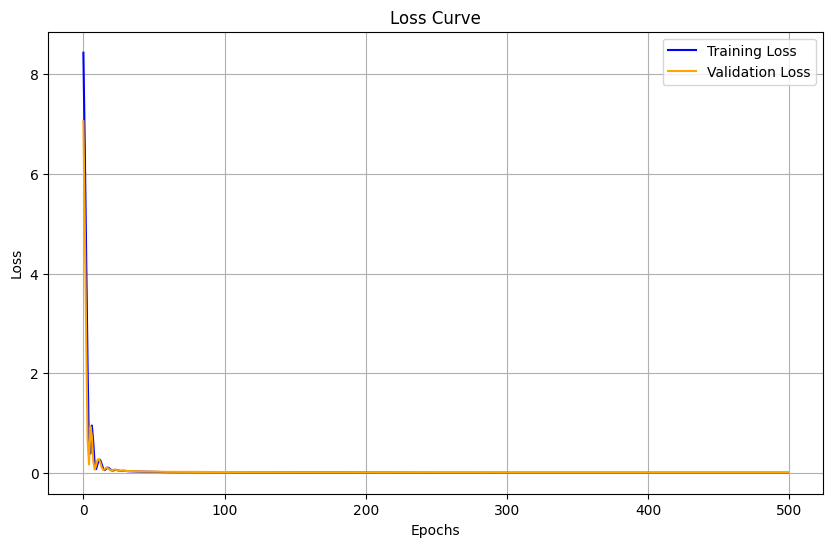

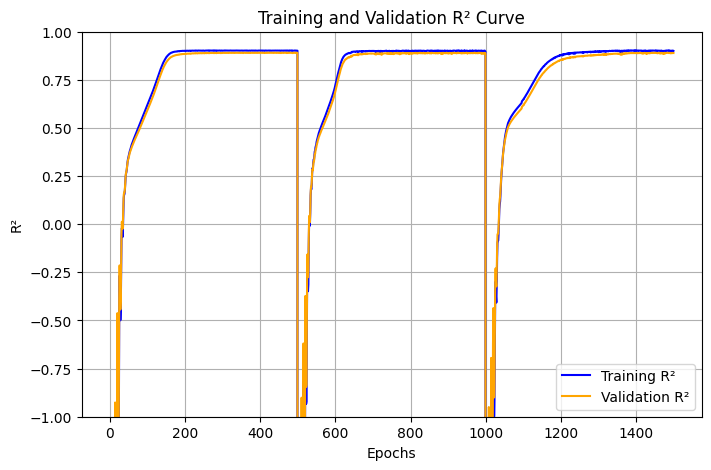

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot R² curves
plt.figure(figsize=(8, 5))
plt.plot(r2_callback.train_r2, label='Training R²', color='blue')
plt.plot(r2_callback.val_r2, label='Validation R²', color='orange')
plt.title('Training and Validation R² Curve')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.ylim(-1, 1)  # Adjust y-axis range for R²
plt.legend()
plt.grid()
plt.show()


# **12. Visualize Predictions**
Plot actual vs. predicted values for the first test group to visualize model performance on unseen data.



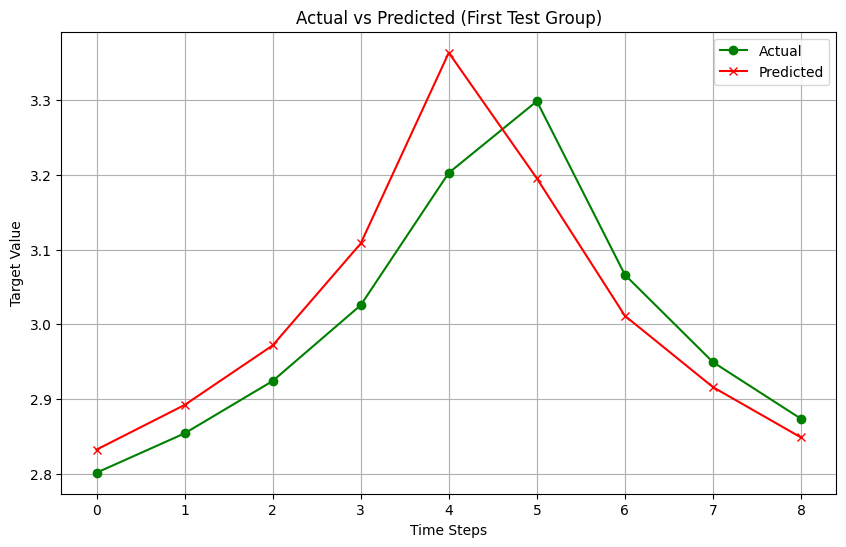

In [ ]:
# Predict and visualize predictions vs actual values for the first group
plt.figure(figsize=(10, 6))
plt.plot(y_test[0], label='Actual', color='green', marker='o')
plt.plot(y_pred[0], label='Predicted', color='red', marker='x')
plt.title('Actual vs Predicted (First Test Group)')
plt.xlabel('Time Steps')
plt.ylabel('Target Value')
plt.legend()
plt.grid()
plt.show()